In [89]:
import imageio.v2 as imageio
import pandas as pd
import skimage.exposure as exp

In [6]:
import os

files = os.listdir("./data")
samples = sorted(set([f.split('.')[0].strip("_enh") for f in files]))

In [7]:
samples

['ExSeq_205',
 'MERFISH_483',
 'RCA_926',
 'deepblink_533',
 'deepspot_360',
 'seqFISH_386',
 'simfish_416']

In [ ]:
imgs = {}
enh_imgs = {}
pred_coords = {}
for i, s in enumerate(samples):
    imgs[s] = imageio.imread(f"./data/{s}.tif")
    enh_imgs[s] = imageio.imread(f"./data/{s}_enh.tif")
    pred_coords[s] = pd.read_csv(f"./data/{s}.csv", index_col=0)

/lib/python3.11/site-packages/imageio/plugins/_tifffile.py:3346: UserWarning: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
  warnings.warn(str(e))


In [22]:
from itertools import product

In [62]:
def sub_df(df, window):
    for i, (s, e) in enumerate(window):
        ser = df.iloc[:, i]
        df = df[(ser > s) & (ser <= e)]
    return df

def find_dense_region(coords, img_shape, window_shape, step=10):
    num_per_axis = [(s - window_shape[i]) // step for i, s in enumerate(img_shape)]
    max_window = None
    max_num = 0
    for idxes in product(*[range(n) for n in num_per_axis]):
        window = [[step * idx, step * idx + window_shape[i]] for i, idx in enumerate(idxes)]
        df = sub_df(coords, window)
        num = df.shape[0]
        if num > max_num:
            max_num = num
            max_window = window
    return max_num, max_window

In [64]:
max_windows = {}
for s in samples:
    max_num, max_windows[s] = find_dense_region(pred_coords[s], imgs[s].shape, [100, 100], 20)
    print(s, max_num, max_windows[s])

ExSeq_205 15 [[140, 240], [0, 100]]
MERFISH_483 110 [[200, 300], [380, 480]]
RCA_926 31 [[180, 280], [60, 160]]
deepblink_533 4 [[80, 180], [100, 200]]
deepspot_360 12 [[80, 180], [200, 300]]
seqFISH_386 66 [[0, 100], [0, 100]]
simfish_416 78 [[320, 420], [100, 200]]


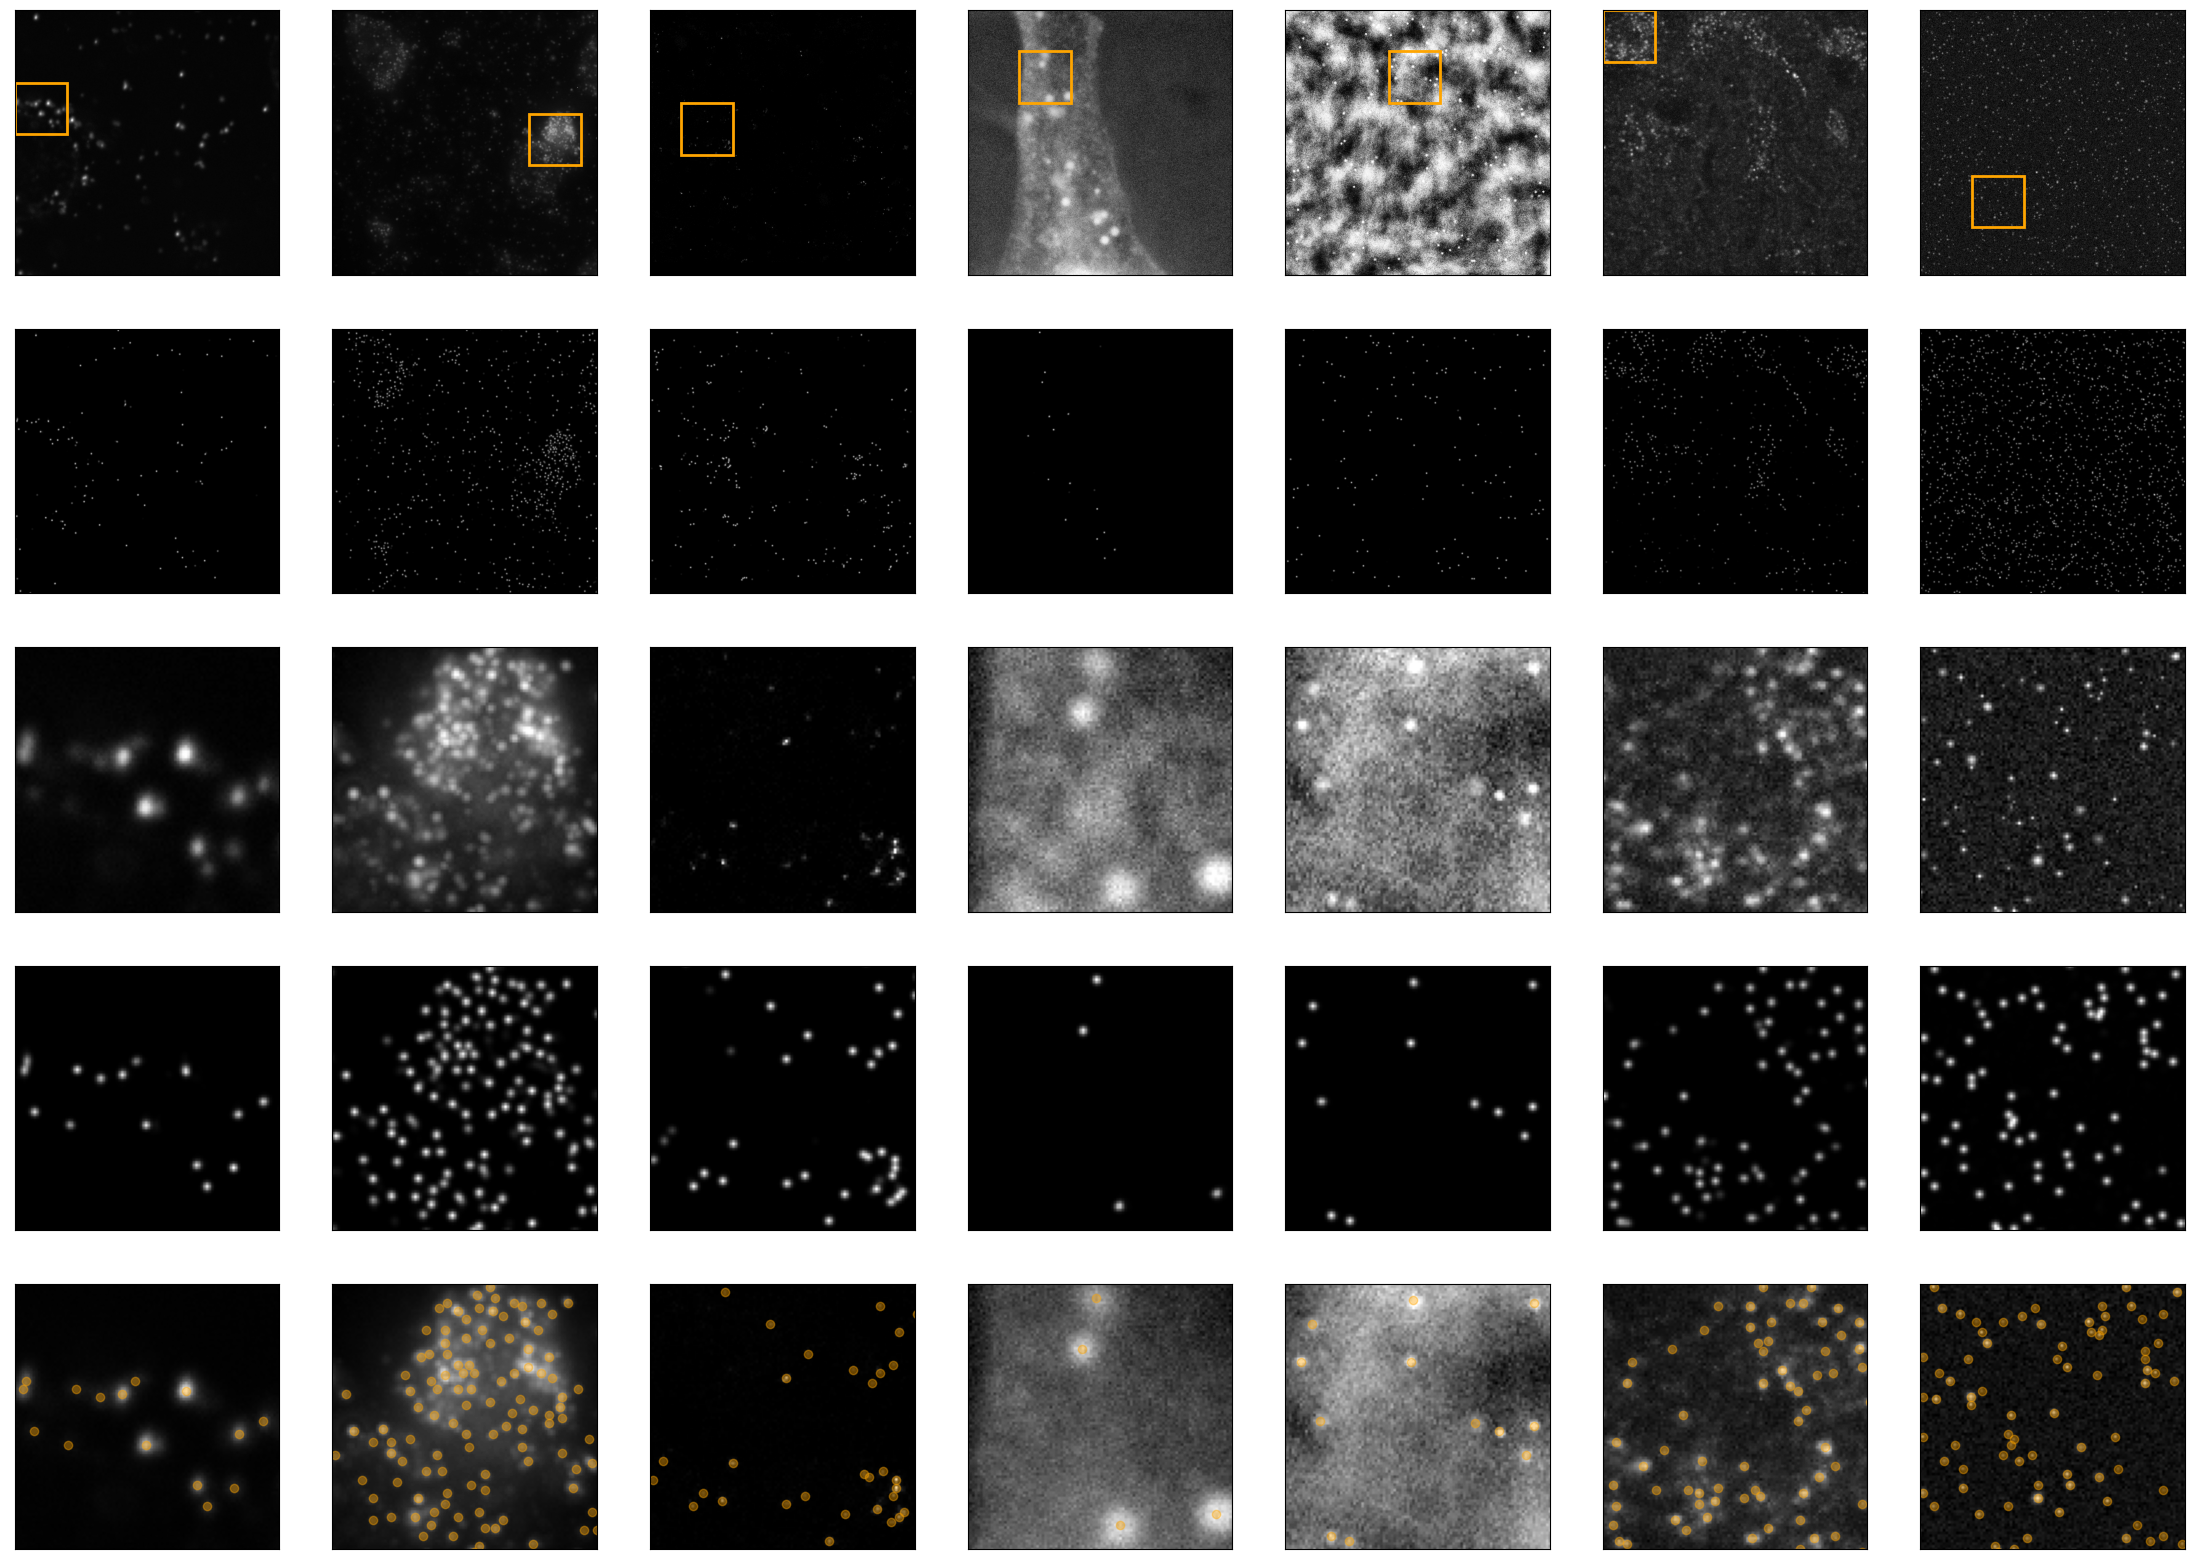

In [95]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

width_per_img = 4
nrows = 5
fig, axes = plt.subplots(
    ncols=len(samples), nrows=nrows,
    figsize=(width_per_img * len(samples), width_per_img*nrows)
)

for i, s in enumerate(samples):
    w = max_windows[s]
    axes[0][i].imshow(exp.equalize_adapthist(imgs[s]), cmap="gray")
    rect = patches.Rectangle(
        (w[1][0], w[0][0]),
        w[1][1]-w[1][0], w[0][1]-w[0][0],
        linewidth=2, edgecolor='orange', facecolor='none')
    axes[0][i].add_patch(rect)
    axes[1][i].imshow(enh_imgs[s], cmap="gray")
    simg = imgs[s][w[0][0]:w[0][1], w[1][0]:w[1][1]]
    axes[2][i].imshow(exp.equalize_adapthist(simg), cmap="gray")
    s_enhimg = enh_imgs[s][w[0][0]:w[0][1], w[1][0]:w[1][1]]
    axes[3][i].imshow(s_enhimg, cmap="gray")
    df = pred_coords[s]
    sdf = sub_df(df, w)
    sdf.iloc[:, 0] -= w[0][0]
    sdf.iloc[:, 1] -= w[1][0]
    axes[4][i].imshow(simg, cmap="gray")
    axes[4][i].set_xlim(0, simg.shape[1]-1)
    axes[4][i].set_ylim(simg.shape[0]-1, 0)
    axes[4][i].scatter(y=sdf.iloc[:,0], x=sdf.iloc[:,1], c='orange', alpha=0.4)
    
for row in axes:
    for ax in row:
        ax.set_xticks([])
        ax.set_yticks([])
        
plt.savefig("run_example.pdf")